In [1]:
import pandas as pd, torch, torch.nn as nn, pickle
from sklearn.model_selection import train_test_split
import glob, os, timeit
import torch.nn.functional as F
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename = '/content/drive/MyDrive/77bins.csv'

chunks = []

# for idx, chunk in enumerate(df):
#   if idx % 10: print(idx)
#   chunks.append(chunk)

chunksize = 10 ** 6
for chunk in pd.read_csv(filename, index_col=0, chunksize=chunksize):
  chunks.append(chunk)

In [4]:
df = chunks[0]
df['Cancer type'] = df['Cancer type'].apply(lambda cell: 'Normal' if cell == 'Normal' else 'Cancerous')
df.head()

,Biosample type,Biosample name,Tissue type,Cancer type,Region number,seq
Sample_0025,Primary Cell,CD56Bright natural killer cell,Blood,Normal,48025,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
Sample_0026,Primary Cell,CD56Bright natural killer cell,Blood,Normal,50447,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
Sample_0027,Primary Cell,CD56Bright natural killer cell,Blood,Normal,47349,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
Sample_0028,Primary Cell,CD56Bright natural killer cell,Blood,Normal,46698,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
Sample_0029,Primary Cell,CD56Dim natural killer cell,Blood,Normal,40745,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...


In [5]:
%load_ext Cython

In [6]:
%%cython

import numpy as np
np.get_include() # do we need this on colab? 
cimport cython
cimport numpy as np

# Adding Z here so we can encode the separator
cdef dict bases={ 'A':<int>0, 'C':<int>1, 'G':<int>2, 'T':<int>3, 'Z':<int>4} 

@cython.boundscheck(False)
def one_hot( str string ):
    cdef np.ndarray[np.float32_t, ndim=2] res = np.zeros( (5,len(string)), dtype=np.float32 )
    cdef int j
    for j in range(len(string)):
        if string[j] in bases: # bases can be 'N' signifying missing: this corresponds to all 0 in the encoding
            res[ bases[ string[j] ], j ]=float(1.0)
    return(res)

In [7]:
data_train, data_rem = train_test_split(df, train_size=0.8, random_state=543)
data_validation, data_test = train_test_split(data_rem, test_size=0.5, random_state=82)
data_train.head()

,Biosample type,Biosample name,Tissue type,Cancer type,Region number,seq
Sample_0243,Other,Bulk_B,Blood,Normal,15623,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
Sample_0893,Cell Line,Jurkat,Blood,Cancerous,82176,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
Sample_0544,Cell Line,U937,Blood,Cancerous,55734,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
Sample_1171,Primary Cell,CD19+ B cell,Blood,Normal,39175,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
Sample_0832,Primary Cell,YF,Blood,Cancerous,10649,ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...


In [8]:
for row in data_train.itertuples():
  print(row[2])
  break

Bulk_B


In [9]:
class BedPeaksDataset(torch.utils.data.IterableDataset):

    def __init__(self, data_set):
        super(BedPeaksDataset, self).__init__()
        self.atac_data = data_set

    def __iter__(self): 
        for i,row in enumerate(self.atac_data.itertuples()):
            seq = row.seq
            value = np.float32(1)
            if row._3 == "Normal":
                value = np.float32(0)
            yield(one_hot(seq), value) # positive example

train_dataset = BedPeaksDataset(data_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, num_workers = 0)

In [10]:
def run_one_epoch(train_flag, dataloader, model, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval() 

    losses = []
    accuracies = []

    for (x,y) in dataloader: # collection of tuples with iterator

        (x, y) = ( x.to(device), y.to(device) ) # transfer data to GPU

        output = model(x) # forward pass
        output = output.squeeze(1) # remove spurious channel dimension
        loss = F.binary_cross_entropy_with_logits( output, y ) # numerically stable

        if train_flag: 
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        accuracy = torch.mean( ( (output > .5) == (y > .5) ).float() )
        accuracies.append(accuracy.detach().cpu().numpy())
    
    return( np.mean(losses), np.mean(accuracies) )

In [11]:
def train_model(model, train_data, validation_data, epochs=100, patience=10, batch_size=1000, verbose = True):
    """
    Train a 1D CNN model and record accuracy metrics.
    """
    # Move the model to the GPU here to make it runs there, and set "device" as above
    # TODO CODE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 1. Make new BedPeakDataset and DataLoader objects for both training and validation data.
    # TODO CODE
    train_dataset = BedPeaksDataset(train_data)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers = 3, timeout=600)
    validation_dataset = BedPeaksDataset(validation_data)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, num_workers = 3, timeout=600)

    # 2. Instantiates an optimizer for the model. 
    # TODO CODE
    optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

    # 3. Run the training loop with early stopping. 
    # TODO CODE
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    patience_counter = patience
    best_val_loss = np.inf
    
    try:
      os.mkdir('./checkpoints')
    except  FileExistsError:
      pass
    
    # Get a list of all the file paths that ends with .txt from in specified directory
    fileList = glob.glob('./checkpoints/model_checkpoint*.pt')
    # Iterate over the list of filepaths & remove each file.
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)
    
    
    check_point_filename = './checkpoints/model_checkpoint.pt' # to save the best model fit to date
    local_min_counter = 0
    for epoch in range(epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc = run_one_epoch(True, train_dataloader, model, optimizer, device)
        val_loss, val_acc = run_one_epoch(False, validation_dataloader, model, optimizer, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if val_loss < best_val_loss: 
            if patience_counter < patience:
                local_min_counter = local_min_counter + 1
            torch.save(model.state_dict(), f'./checkpoints/model_checkpoint-{local_min_counter}.pt')
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                model.load_state_dict(torch.load(f'./checkpoints/model_checkpoint-{local_min_counter}.pt')) # recover the best model so far
                break
        elapsed = float(timeit.default_timer() - start_time)
        print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" % 
              (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))

    # 4. Return the fitted model (not strictly necessary since this happens "in place"), train and validation accuracies.
    # TODO CODE
    return model, train_accs, val_accs, train_losses, val_losses, validation_dataloader

In [12]:
class LSTM(nn.Module):

    def __init__(self, 
                 n_output_channels = 1, 
                 n_hidden = 32, 
                 dropout = 0.2,
                 n_fc = 1,
                 lstm_hidden=10):
        
        super(LSTM, self).__init__()
        self.lstm = nn.Sequential(nn.GRU(5, lstm_hidden, batch_first=True, dropout=dropout))
        self.trans = nn.TransformerEncoderLayer(d_model=5, nhead=5, batch_first=True)
        fc_layers = [nn.Linear(lstm_hidden, n_hidden)]
        for i in range(n_fc-1):
            fc_layers += [ nn.Dropout(dropout),
                          nn.ELU(inplace=True),
                          nn.Linear(n_hidden, n_hidden)
            ]
        fc_layers += [nn.Dropout(dropout),
                      nn.ELU(inplace=True),
                      nn.Linear(n_hidden, n_output_channels)
        ]
        self.dense_net = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = x.transpose(1, 2)
        # x = self.trans(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = out.view(out.size(0), -1)
        out = self.dense_net(out)
        return out

In [15]:
torch.cuda.empty_cache()

lstm_model = LSTM(dropout=0, n_hidden=32, n_fc=2, lstm_hidden=2)

lstm_model, train_accs, val_accs, train_losses, val_losses, lstm_validation_datloader = train_model(lstm_model, data_train
                                                                         , data_validation, epochs=1
                                                                         , patience=20, batch_size=1)

KeyboardInterrupt: ignored

In [ ]:
# torch.Size([361, 5, 770000])
while True: pass
X = torch.rand(1, 1000, 5)
GRU = nn.TransformerEncoder(d_model=40, nhead=8, batch_first=True)
o, h = GRU(X)
o.shape, h.shape

In [4]:
filename = '/content/drive/MyDrive/percents.csv'
key_bins = ['125955', '123912', '269320', '272922', '98843', '129054', '260129', '8226', '288802', '266280', '79921', '44083', '233011', '18485', '48195', '282195', '79956', '219770', '219771', '219772', '265852', '40059', '88188', '175753', '78999', '24728', '129687', '68766', '68767', '194208', '303774', '230563', '65193', '181434', '34495', '305866', '99532', '88273', '139474', '305879', '46313', '2795', '133356', '274160', '285943', '87799', '196354', '212738', '83720', '16141', '16143', '139538', '165661', '250156', '48943', '152380', '240958', '106304', '200028', '31591', '96110', '258421', '108413', '287619', '280981', '33689', '33697', '250791', '139178', '257965', '92082', '123314', '247738', '34758', '11728', '25047', '253439']
cols_needed = ['Unnamed: 0', 'Biosample type', 'Biosample name', 'Tissue type', 'Cancer type', 'Region number']

df = pd.read_csv(filename, index_col=0, usecols=key_bins + cols_needed)

In [5]:
df['Target'] = df['Cancer type'].apply(lambda cell: 0 if cell == 'Normal' else 1)
df = df.drop(['Biosample type', 'Biosample name', 'Tissue type', 'Cancer type', 'Region number'], axis=1)

In [6]:
import sklearn
X, y = df.iloc[:, :-1], df.iloc[:,-1]
X

,2795,8226,11728,16141,16143,18485,24728,25047,31591,33689,...,272922,274160,280981,282195,285943,287619,288802,303774,305866,305879
Sample_0025,0.3296,0.0,0.1137,0.1930,0.1931,0.0560,0.1102,0.0000,0.2380,0.2036,...,0.1968,0.0854,0.3967,0.0000,0.1573,0.2230,0.1122,0.0000,0.0000,0.0000
Sample_0026,0.2716,0.0,0.1119,0.1886,0.2083,0.0441,0.0647,0.0000,0.1875,0.3942,...,0.1553,0.0510,0.3694,0.0492,0.1211,0.2378,0.0780,0.0000,0.4132,0.4175
Sample_0027,0.2054,0.0,0.0998,0.0730,0.0000,0.0429,0.2379,0.6225,0.1662,0.5934,...,0.1906,0.0000,0.2684,0.0000,0.0124,0.0856,0.0463,0.6411,0.2242,0.1836
Sample_0028,0.1332,0.0,0.0955,0.0336,0.0000,0.0441,0.2398,0.5812,0.1187,0.7875,...,0.1782,0.0000,0.3470,0.0000,0.0190,0.0516,0.0591,0.3899,0.6777,0.5182
Sample_0029,0.3013,0.0,0.0619,0.1342,0.1442,0.0369,0.1462,0.0790,0.0832,0.5729,...,0.1614,0.1334,0.2754,0.0000,0.0000,0.0762,0.0829,0.1243,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_1467,0.0000,0.0,0.0000,0.0355,0.0915,0.0000,0.0309,0.2586,0.0000,0.5067,...,0.0855,0.0000,0.0000,0.0000,0.0345,0.0374,0.0000,0.0000,0.0000,0.0000
Sample_1468,0.0000,0.0,0.0000,0.0279,0.0828,0.0000,0.0353,0.0000,0.0000,0.4917,...,0.0719,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Sample_1469,0.0000,0.0,0.0000,0.0322,0.1399,0.0000,0.0334,0.1516,0.0000,0.5964,...,0.0541,0.0000,0.0351,0.0000,0.0000,0.0276,0.0000,0.1461,0.0000,0.0000
Sample_1470,0.0000,0.0,0.0000,0.0528,0.1098,0.0000,0.0000,0.3003,0.0000,0.5410,...,0.0691,0.0000,0.0000,0.0000,0.0000,0.0347,0.0000,0.0000,0.0000,0.0000


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

In [8]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score, roc_curve, plot_roc_curve
import matplotlib.pyplot as plt

for thresh in np.linspace(0, 1, 11):
  print("thresh:", thresh, ", acc:", accuracy_score(y_test, preds > thresh))

thresh: 0.0 , acc: 0.38461538461538464
thresh: 0.1 , acc: 0.38461538461538464
thresh: 0.2 , acc: 0.6373626373626373
thresh: 0.30000000000000004 , acc: 0.8131868131868132
thresh: 0.4 , acc: 0.9010989010989011
thresh: 0.5 , acc: 0.9120879120879121
thresh: 0.6000000000000001 , acc: 0.8351648351648352
thresh: 0.7000000000000001 , acc: 0.7472527472527473
thresh: 0.8 , acc: 0.6263736263736264
thresh: 0.9 , acc: 0.6153846153846154
thresh: 1.0 , acc: 0.6153846153846154


In [10]:
from sklearn import svm

clf = svm.SVC(random_state=0)
clf.fit(X_train, y_train)
preds_svm = clf.predict(X_test)

In [12]:
accuracy_score(y_test, preds_svm)

0.8461538461538461

In [11]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

print('XGBoost')
tpr = sklearn.metrics.recall_score(y_test, preds > 0.5)
f1 = sklearn.metrics.f1_score(y_test, preds > 0.5)
precision = sklearn.metrics.precision_score(y_test, preds > 0.5)
print(f'prec: {precision}, tpr: {tpr}, f1: {f1}')
print('SVM')
tpr = sklearn.metrics.recall_score(y_test, preds_svm)
f1 = sklearn.metrics.f1_score(y_test, preds_svm)
precision = sklearn.metrics.precision_score(y_test, preds_svm)
print(f'prec: {precision}, tpr: {tpr}, f1: {f1}')

XGBoost
prec: 0.9090909090909091, tpr: 0.8571428571428571, f1: 0.8823529411764706
SVM
prec: 0.7441860465116279, tpr: 0.9142857142857143, f1: 0.8205128205128205


In [13]:
def calculate_cm(y_true, y_pred):
  fp = np.sum((y_pred == 1) & (y_true == 0))
  tp = np.sum((y_pred == 1) & (y_true == 1))

  fn = np.sum((y_pred == 0) & (y_true == 1))
  tn = np.sum((y_pred == 0) & (y_true == 0))
  return tp, fp, fn, tn

def calculate_recall(tp, fp, fn, tn):
  return (tp)/(tp + fn)

def calculate_fallout(tp, fp, fn, tn):
  return (fp)/(fp + tn)

tp, fp, fn, tn = calculate_cm(y_test, preds_svm)
print(calculate_recall(tp, fp, fn, tn))
print(calculate_fallout(tp,fp,fn,tn))

0.9142857142857143
0.19642857142857142


In [14]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso

linear = LinearRegression()
linear.fit(X_train, y_train)
preds_ln = linear.predict(X_test)

In [15]:
# for thresh in np.linspace(0, 1, 11):
#   print("thresh:", thresh, ", acc:", accuracy_score(y_test, preds_ln > thresh))
thresh = 0.5
tpr = sklearn.metrics.recall_score(y_test, preds_ln > thresh)
f1 = sklearn.metrics.f1_score(y_test, preds_ln > thresh)
precision = sklearn.metrics.precision_score(y_test, preds_ln > thresh)
print(f"acc: {accuracy_score(y_test, preds_ln > thresh)}")
print(f'prec: {precision}, tpr: {tpr}, f1: {f1}')
tp, fp, fn, tn = calculate_cm(y_test, preds_ln > thresh)
print(calculate_recall(tp, fp, fn, tn))
print(calculate_fallout(tp,fp,fn,tn))

acc: 0.8681318681318682
prec: 0.8709677419354839, tpr: 0.7714285714285715, f1: 0.8181818181818182
0.7714285714285715
0.07142857142857142


In [16]:
from sklearn.model_selection import cross_val_score

def run_cv(model):
  # - cross validataion
  scores = cross_val_score(model, X_train, y_train, cv=5)
  print("Mean cross-validation score: %.2f" % scores.mean())

  y_pred = model.predict(X_test)
  if type(y_pred[0]) == np.float32 or type(y_pred[0]) == np.float64:
    cm = confusion_matrix(y_test,y_pred > 0.5)
  else:
    cm = confusion_matrix(y_test,y_pred)
  print(cm)

In [17]:
run_cv(xg_reg)
run_cv(clf)
run_cv(linear)

Mean cross-validation score: 0.38
[[53  3]
 [ 5 30]]
Mean cross-validation score: 0.79
[[45 11]
 [ 3 32]]
Mean cross-validation score: 0.34
[[52  4]
 [ 8 27]]


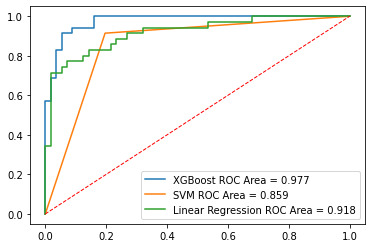

In [18]:
from sklearn.metrics import roc_auc_score

fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, preds, drop_intermediate=True)
auc_xgb = roc_auc_score(y_test, preds)
fpr_svm, tpr_svm, thresholds = roc_curve(y_test, preds_svm, drop_intermediate=True)
auc_svm = roc_auc_score(y_test, preds_svm)
fpr_lin, tpr_lin, thresholds = roc_curve(y_test, preds_ln, drop_intermediate=True)
auc_lin = roc_auc_score(y_test, preds_ln)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost ROC Area = {auc_xgb:.3}")
plt.plot(fpr_svm, tpr_svm, label=f"SVM ROC Area = {auc_svm:.3}")
plt.plot(fpr_lin, tpr_lin, label=f"Linear Regression ROC Area = {auc_lin:.3}")
plt.plot([0, 1], [0, 1], '--r', lw=1)
plt.legend()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=50)
pca.fit(X_train)

In [ ]:
X_train_pcs = pca.transform(X_train)
X_test_pcs = pca.transform(X_test)

In [19]:
from sklearn.preprocessing import MinMaxScaler

ln_pc = LinearRegression()
# scaler = MinMaxScaler()
# scaler.fit(X_train_pcs)
# X_train_pcs = scaler.transform(X_train_pcs)
# X_test_pcs = scaler.transform(X_test_pcs)
ln_pc.fit(X_train, y_train)
preds_pcs = ln_pc.predict(X_test)

In [20]:
data_train, data_rem = train_test_split(df, train_size=0.8, random_state=543)
data_validation, data_test = train_test_split(data_rem, test_size=0.5, random_state=82)

In [ ]:
pca.fit(data_train.iloc[:,:-1])

In [23]:
data_train_y, data_train_new = data_train.iloc[:,-1], data_train.iloc[:,:-1]
# scaler.fit(data_train_new)
# data_train_new = scaler.transform(data_train_new)
data_val_y, data_validation_new = data_validation.iloc[:,-1], data_validation.iloc[:,:-1]
# data_validation_new = scaler.transform(data_validation_new)
data_test_y, data_test_new = data_test.iloc[:,-1], data_test.iloc[:,:-1]
# data_test_new = scaler.transform(data_test_new)

In [21]:
confusion_matrices = {}
models = {0: "Linear Regression", 1: "Ridge Regression", 2: "Lasso Regression", 3: "SVM", 4: "XGBoost", 5: "Logistic Regression", 6: "DNN"}

In [36]:
lin = LinearRegression()
lin.fit(data_train_new, data_train_y)
val_preds_lin = lin.predict(data_test_new)
confusion_matrices["Linear Regression"] = confusion_matrix(data_test_y, val_preds_lin > 0.25)

thresh = 0.3
tpr = sklearn.metrics.recall_score(data_test_y, val_preds_lin > thresh)
f1 = sklearn.metrics.f1_score(data_test_y, val_preds_lin > thresh)
precision = sklearn.metrics.precision_score(data_test_y, val_preds_lin > thresh)
print(f"acc: {accuracy_score(data_test_y, val_preds_lin > thresh)}")
print(f'prec: {precision}, tpr: {tpr}, f1: {f1}')
tp, fp, fn, tn = calculate_cm(data_test_y, val_preds_lin > thresh)
print(calculate_recall(tp, fp, fn, tn))
print(calculate_fallout(tp,fp,fn,tn))

acc: 0.8478260869565217
prec: 0.7142857142857143, tpr: 0.9375, f1: 0.8108108108108109
0.9375
0.2


In [26]:
svmm = svm.SVC()
svmm.fit(data_train_new, data_train_y)
val_preds_svm = svmm.predict(data_test_new)
confusion_matrices["SVM"] = confusion_matrix(data_test_y, val_preds_svm)

thresh = 0.5
tpr = sklearn.metrics.recall_score(data_test_y, val_preds_svm > thresh)
f1 = sklearn.metrics.f1_score(data_test_y, val_preds_svm > thresh)
precision = sklearn.metrics.precision_score(data_test_y, val_preds_svm > thresh)
print(f"acc: {accuracy_score(data_test_y, val_preds_svm > thresh)}")
print(f'prec: {precision}, tpr: {tpr}, f1: {f1}')
tp, fp, fn, tn = calculate_cm(data_test_y, val_preds_svm > thresh)
print(calculate_recall(tp, fp, fn, tn))
print(calculate_fallout(tp,fp,fn,tn))

acc: 0.8695652173913043
prec: 0.75, tpr: 0.9375, f1: 0.8333333333333334
0.9375
0.16666666666666666


In [37]:
rid = Ridge(alpha=0.01)
rid.fit(data_train_new, data_train_y)
val_preds_rid = rid.predict(data_test_new)
confusion_matrices["Ridge Regression"] = confusion_matrix(data_test_y, val_preds_rid > 0.27)

thresh = 0.4
tpr = sklearn.metrics.recall_score(data_test_y, val_preds_rid > thresh)
f1 = sklearn.metrics.f1_score(data_test_y, val_preds_rid > thresh)
precision = sklearn.metrics.precision_score(data_test_y, val_preds_rid > thresh)
print(f"acc: {accuracy_score(data_test_y, val_preds_rid > thresh)}")
print(f'prec: {precision}, tpr: {tpr}, f1: {f1}')
tp, fp, fn, tn = calculate_cm(data_test_y, val_preds_rid > thresh)
print(calculate_recall(tp, fp, fn, tn))
print(calculate_fallout(tp,fp,fn,tn))

acc: 0.8695652173913043
prec: 0.8125, tpr: 0.8125, f1: 0.8125
0.8125
0.1


In [43]:
lasso = Lasso(alpha=0.01)
lasso.fit(data_train_new, data_train_y)
val_preds_lasso = lasso.predict(data_test_new)
confusion_matrices["Lasso Regression"] = confusion_matrix(data_test_y, val_preds_lasso > 0.36)

thresh = 0.4
tpr = sklearn.metrics.recall_score(data_test_y, val_preds_lasso > thresh)
f1 = sklearn.metrics.f1_score(data_test_y, val_preds_lasso > thresh)
precision = sklearn.metrics.precision_score(data_test_y, val_preds_lasso > thresh)
print(f"acc: {accuracy_score(data_test_y, val_preds_lasso > thresh)}")
print(f'prec: {precision}, tpr: {tpr}, f1: {f1}')
tp, fp, fn, tn = calculate_cm(data_test_y, val_preds_lasso > thresh)
print(calculate_recall(tp, fp, fn, tn))
print(calculate_fallout(tp,fp,fn,tn))

acc: 0.7608695652173914
prec: 0.631578947368421, tpr: 0.75, f1: 0.6857142857142857
0.75
0.23333333333333334


In [44]:
log = LogisticRegression()
log.fit(data_train_new, data_train_y)
val_preds_log = log.predict(data_test_new)
confusion_matrices["Logistic Regression"] = confusion_matrix(data_test_y, val_preds_log > 0.4)

thresh = 0.3
tpr = sklearn.metrics.recall_score(data_test_y, val_preds_log > thresh)
f1 = sklearn.metrics.f1_score(data_test_y, val_preds_log > thresh)
precision = sklearn.metrics.precision_score(data_test_y, val_preds_log > thresh)
print(f"acc: {accuracy_score(data_test_y, val_preds_log > thresh)}")
print(f'prec: {precision}, tpr: {tpr}, f1: {f1}')
tp, fp, fn, tn = calculate_cm(data_test_y, val_preds_log > thresh)
print(calculate_recall(tp, fp, fn, tn))
print(calculate_fallout(tp,fp,fn,tn))

acc: 0.8478260869565217
prec: 0.8, tpr: 0.75, f1: 0.7741935483870969
0.75
0.1


In [30]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(data_train_new,data_train_y)

preds_xgb = xg_reg.predict(data_test_new)
confusion_matrices["XGBoost"] = confusion_matrix(data_test_y, preds_xgb > 0.5)

thresh = 0.4
tpr = sklearn.metrics.recall_score(data_test_y, preds_xgb > thresh)
f1 = sklearn.metrics.f1_score(data_test_y, preds_xgb > thresh)
precision = sklearn.metrics.precision_score(data_test_y, preds_xgb > thresh)
print(f"acc: {accuracy_score(data_test_y, preds_xgb > thresh)}")
print(f'prec: {precision}, tpr: {tpr}, f1: {f1}')
tp, fp, fn, tn = calculate_cm(data_test_y, preds_xgb > thresh)
print(calculate_recall(tp, fp, fn, tn))
print(calculate_fallout(tp,fp,fn,tn))

acc: 0.9130434782608695
prec: 0.8, tpr: 1.0, f1: 0.888888888888889
1.0
0.13333333333333333


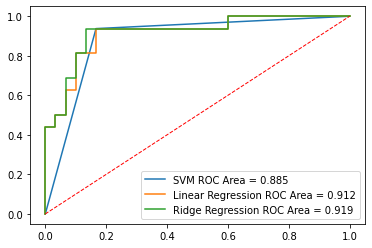

In [31]:
from sklearn.metrics import roc_auc_score

fpr_svm, tpr_svm, thresholds = roc_curve(data_test_y, val_preds_svm, drop_intermediate=True)
auc_svm = roc_auc_score(data_test_y, val_preds_svm)
fpr_lin, tpr_lin, thresholds = roc_curve(data_test_y, val_preds_lin, drop_intermediate=True)
auc_lin = roc_auc_score(data_test_y, val_preds_lin)
fpr_rid, tpr_rid, thresholds = roc_curve(data_test_y, val_preds_rid, drop_intermediate=True)
auc_rid = roc_auc_score(data_test_y, val_preds_rid)
plt.plot(fpr_svm, tpr_svm, label=f"SVM ROC Area = {auc_svm:.3}")
plt.plot(fpr_lin, tpr_lin, label=f"Linear Regression ROC Area = {auc_lin:.3}")
plt.plot(fpr_rid, tpr_rid, label=f"Ridge Regression ROC Area = {auc_rid:.3}")
plt.plot([0, 1], [0, 1], '--r', lw=1)
plt.legend()

In [45]:
nn = np.array([
          [28, 2],
          [3 , 13]
])
# ({'FN': 3, 'FP': 2, 'TN': 28, 'TP': 13})
confusion_matrices["DNN"] = nn

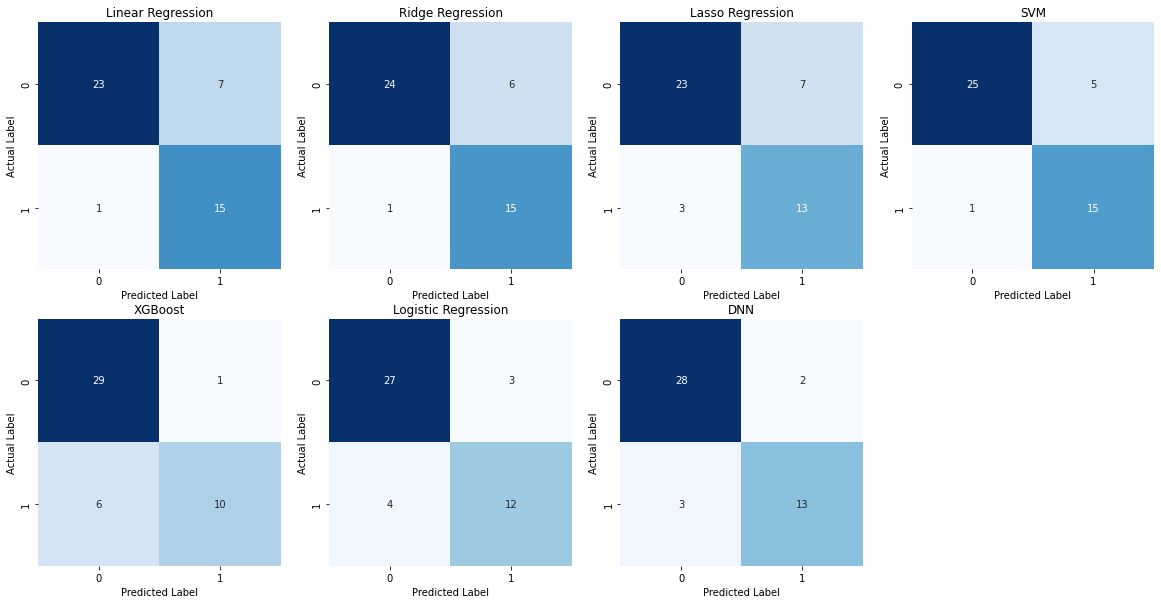

In [46]:
import seaborn as sns

plt.figure(figsize=(20,10))
for i in range(8):
  if i < 7:
      model = models[i]
      plt.subplot(2,4,i+1)
      plt.grid(0)
      sns.heatmap(confusion_matrices[model], cmap='Blues', annot=True, cbar=False)
      plt.title(f"{model}")
      plt.xlabel("Predicted Label")
      plt.ylabel("Actual Label")
plt.show()